##### Notatki
Tutorial tutaj: https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

Dane Flickr 8k:
https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

Polskie podpisy: http://zil.ipipan.waw.pl/Scwad/AIDe?action=AttachFile&do=get&target=AIDe_ANNOTATED_DESCRIPTIONS.zip

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import tensorflow as tf
from unidecode import unidecode

Using TensorFlow backend.


In [2]:
i = input("Czy używamy polskich znaków?(Y/N)")

polish_letters = i.lower() == 'y'

Czy używamy polskich znaków?(Y/N)y


In [3]:
import csv

captions_filename = f'../AIDe_ANNOTATED_DESCRIPTIONS/captions.csv'
tokens_filename = f'../AIDe_ANNOTATED_DESCRIPTIONS/token{"" if polish_letters else "-NO-PL"}.txt'
train_filename = f'../AIDe_ANNOTATED_DESCRIPTIONS/trainImages.txt'
test_filename = f'../AIDe_ANNOTATED_DESCRIPTIONS/testImages.txt'
descriptions_filename = f'descriptions-{"PL" if polish_letters else "NO-PL"}.txt'

# Polski zbiór podpisów uwzględnia jedynia 1k obrazów z Flickr
train_size = 750

with open(captions_filename, newline='', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='\t')
    img_names = []
    next(reader)
    with open(tokens_filename, 'w') as ft:
        for row in reader:
            img_name = row[1]
            caption1 = row[2] if polish_letters else unidecode(row[2])
            caption2 = row[3] if polish_letters else unidecode(row[3])
            print(f'{img_name}#0\t{caption1}', file=ft)
            print(f'{img_name}#1\t{caption2}', file=ft)
            img_names.append(img_name)

    with open(train_filename, 'w') as ft:
        for name in img_names[:train_size]:
            print(name, file=ft) 
    with open(test_filename, 'w') as ft:
        for name in img_names[train_size:]:
            print(name, file=ft) 

In [4]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load descriptions
doc = load_doc(tokens_filename)
print(doc[:300])

1355703632_5683a4b6fb.jpg#0	Młoda osoba w sportowym stroju i rękawicy robi duży krok, trzymając w jednej dłoni piłkę.
1355703632_5683a4b6fb.jpg#1	Dziewczyna z rękawicą na ręce biegnie po boisku z żółtą piłką w drugiej ręce.
2101128963_fdf8b2a0d7.jpg#0	Zawodnik na boisku ze skórzaną rękawicą robi wyk


In [5]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 1000 


In [6]:
list(descriptions.keys())[:5]

['1355703632_5683a4b6fb',
 '2101128963_fdf8b2a0d7',
 '241345522_c3c266a02a',
 '241347460_81d5d62bf6',
 '2521938802_853224f378']

In [7]:
descriptions['1355703632_5683a4b6fb']

['Młoda osoba w sportowym stroju i rękawicy robi duży krok, trzymając w jednej dłoni piłkę.',
 'Dziewczyna z rękawicą na ręce biegnie po boisku z żółtą piłką w drugiej ręce.']

In [8]:
descriptions['2521938802_853224f378']

['Mężczyzna w białym sportowym stroju i czarnym kasku stoi na trawie na zgiętych nogach, trzymając za plecami grubą pałkę.',
 'Mężczyzna z ochraniaczami na nogach stoi na trawie w rozkroku.']

In [9]:
import spacy
nlp = spacy.load('pl_spacy_model')

def clean_descriptions(descriptions):
  # prepare translation table for removing punctuation
  table = str.maketrans('', '', string.punctuation)
  for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
      desc = desc_list[i]
      doc = nlp(desc)
      # tokenize
      desc = desc.split()
      # convert to lower case
      desc = [word.lower() for word in desc]
# Lematyzacja
#### spacy model from here: http://zil.ipipan.waw.pl/SpacyPL?action=AttachFile&do=view&target=pl_spacy_model-0.1.0.tar.gz
#### spacy dokumentacja - https://spacy.io/usage
      desc = [word.lemma_ for word in doc]
      # remove punctuation from each token
      desc = [w.translate(table) for w in desc]
      # remove tokens with numbers in them
      desc = [word for word in desc if word.isalpha()]
      # store as string
      desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [10]:
descriptions['1355703632_5683a4b6fb']

['młoda osoba w sportowym stroju i rękawicy robi duży krok trzymając w jednej dłoni piłkę',
 'dziewczyna z rękawicą na ręce biegnie po boisku z żółtą piłką w drugiej ręce']

In [11]:
descriptions['2521938802_853224f378']

['mężczyzna w białym sportowym stroju i czarnym kasku stoi na trawie na zgiętych nogach trzymając za plecami grubą pałkę',
 'mężczyzna z ochraniaczami na nogach stoi na trawie w rozkroku']

In [12]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 3273


In [13]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w', encoding='utf-8')
	file.write(data)
	file.close()

save_descriptions(descriptions, descriptions_filename)

In [14]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
train = load_set(train_filename)
print('Dataset: %d' % len(train))

Dataset: 750


In [15]:
# Below path contains all the images
images = '../Flickr8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [16]:
# Read the train image names in a set
train_images = set(open(train_filename, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [17]:
# Below file conatains the names of images to be used in test data
test_images_file = test_filename
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [18]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions(descriptions_filename, train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=750


In [19]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [20]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [21]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [22]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

###### Notatki
Poniższy kod zajmuje bardzo dużo czasu.

In [23]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
    print('.', end='')
print("Time taken in seconds =", time()-start)

..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Time taken in seconds = 106.02694749832153


In [24]:
import os
import pickle

writepath = f'../Pickle/encoded_train_images_{"pl" if polish_letters else "no_pl"}.pkl'

mode = 'a' if os.path.exists(writepath) else 'wb'

# Save the bottleneck train features to disk
with open(f'../Pickle/encoded_train_images_{"pl" if polish_letters else "no_pl"}.pkl', "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [25]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
    print('.', end='')
print("Time taken in seconds =", time()-start)

..........................................................................................................................................................................................................................................................Time taken in seconds = 34.83125829696655


In [26]:
# Save the bottleneck test features to disk
with open(f'../Pickle/encoded_test_images_{"pl" if polish_letters else "no_pl"}.pkl', "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [27]:
train_features = load(open(f'../Pickle/encoded_train_images_{"pl" if polish_letters else "no_pl"}.pkl', "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=750


In [28]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

1500

In [29]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 2793 -> 249


In [30]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [31]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

250

In [32]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 36


In [33]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
#                 yield [[array(X1), array(X2)], array(y)]
                yield ([array(X1), array(X2)], array(y)) 
                X1, X2, y = list(), list(), list()
                n=0

Embedings pobrane stąd: https://github.com/sdadas/polish-nlp-resources/releases/download/v1.0/glove.zip

In [34]:
# Load Glove vectors
glove_dir = '../glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove_100_3_polish.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0] if polish_letters else unidecode(values[0])
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 1926321 word vectors.


In [35]:
embedding_dim = 100

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [36]:
embedding_matrix.shape

(250, 100)

In [37]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [38]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 36)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 36, 100)      25000       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [39]:
model.layers[2]

In [40]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [41]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [42]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

Kolejny dość czasochłonny krok

In [43]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    print(generator)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    writepath = f'../model_weights/model_{str(i)}_{"pl" if polish_letters else "no_pl"}.h5'

    mode = 'a' if os.path.exists(writepath) else 'wb'
#     file = open(writepath, mode)
    model.save(writepath)

<generator object data_generator at 0x000001F5F029DC48>
Epoch 1/1
250/250 [==============================] - 28s 113ms/step - loss: 4.3909
<generator object data_generator at 0x000001F5F100B3C8>
Epoch 1/1
250/250 [==============================] - 28s 111ms/step - loss: 3.9088
<generator object data_generator at 0x000001F5F36EFBC8>
Epoch 1/1
250/250 [==============================] - 27s 109ms/step - loss: 3.6624
<generator object data_generator at 0x000001F5F029DC48>
Epoch 1/1
250/250 [==============================] - 28s 110ms/step - loss: 3.5061
<generator object data_generator at 0x000001F5F36EFD48>
Epoch 1/1
250/250 [==============================] - 28s 111ms/step - loss: 3.3851
<generator object data_generator at 0x000001F5F100B3C8>
Epoch 1/1
250/250 [==============================] - 28s 113ms/step - loss: 3.2504
<generator object data_generator at 0x000001F5F36EFBC8>
Epoch 1/1
250/250 [==============================] - 29s 115ms/step - loss: 3.1341
<generator object data_gene

In [44]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save(f'../model_weights/model_{str(i)}_{"pl" if polish_letters else "no_pl"}.h5')

Epoch 1/1
250/250 [==============================] - 25s 98ms/step - loss: 2.7969
Epoch 1/1
250/250 [==============================] - 24s 96ms/step - loss: 2.7048
Epoch 1/1
250/250 [==============================] - 30s 118ms/step - loss: 2.5932
Epoch 1/1
250/250 [==============================] - 27s 107ms/step - loss: 2.5007
Epoch 1/1
250/250 [==============================] - 27s 107ms/step - loss: 2.4079
Epoch 1/1
250/250 [==============================] - 27s 108ms/step - loss: 2.3407
Epoch 1/1
250/250 [==============================] - 30s 119ms/step - loss: 2.2917
Epoch 1/1
250/250 [==============================] - 26s 104ms/step - loss: 2.2010
Epoch 1/1
250/250 [==============================] - 26s 103ms/step - loss: 2.0917
Epoch 1/1
250/250 [==============================] - 27s 106ms/step - loss: 1.9889


In [45]:
# model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [46]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
125/125 [==============================] - 20s 160ms/step - loss: 2.0643
Epoch 1/1
125/125 [==============================] - 21s 167ms/step - loss: 2.0240
Epoch 1/1
125/125 [==============================] - 19s 154ms/step - loss: 2.0083
Epoch 1/1
125/125 [==============================] - 19s 151ms/step - loss: 1.9719
Epoch 1/1
125/125 [==============================] - 19s 150ms/step - loss: 1.9249
Epoch 1/1
125/125 [==============================] - 19s 150ms/step - loss: 1.8629
Epoch 1/1
125/125 [==============================] - 20s 160ms/step - loss: 1.7970
Epoch 1/1
125/125 [==============================] - 20s 158ms/step - loss: 1.7308
Epoch 1/1
125/125 [==============================] - 21s 166ms/step - loss: 1.6700
Epoch 1/1
125/125 [==============================] - 22s 172ms/step - loss: 1.6224


In [47]:
model.save_weights(f'../model_weights/model_30_{"pl" if polish_letters else "no_pl"}.h5')

In [48]:
model.load_weights(f'../model_weights/model_30_{"pl" if polish_letters else "no_pl"}.h5')

In [49]:
images = '../Flickr8k_Dataset/'

In [50]:
with open(f'../Pickle/encoded_test_images_{"pl" if polish_letters else "no_pl"}.pkl', "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [51]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

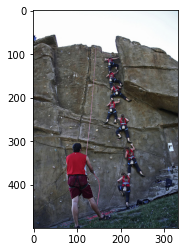

Greedy: chĹ‚opiec w czapce z na


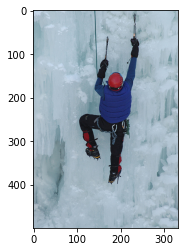

Greedy: dziewczynka w i czerwonym stroju zjeĹĽdĹĽa z gĂłry


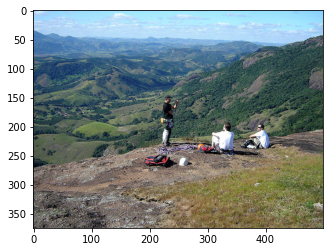

Greedy: czĹ‚owiek w stoi z na


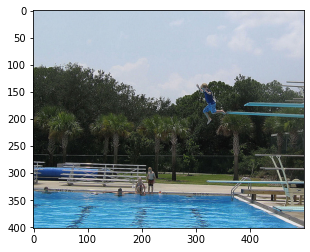

Greedy: chĹ‚opiec dzieci siÄ™ na deskorolce w pobliĹĽu


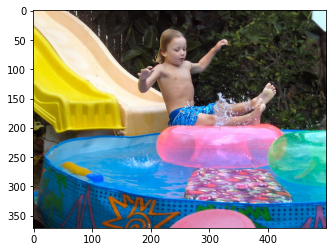

Greedy: dziewczynka pĹ‚ywa na chodniku w basenie


In [52]:
for i in range(0,5):
    pic = list(encoding_test.keys())[i]
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print("Greedy:",greedySearch(image))

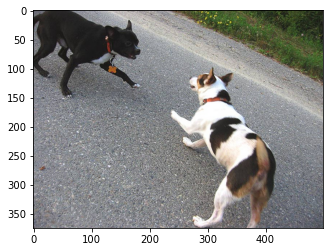

Greedy: maĹ‚y pies z obroĹĽÄ… na szyi skacze po trawie
['dwa psy jeden czarny a drugi łaciaty stoją naprzeciwko siebie na ulicy', 'dwa psy stoją naprzeciwko siebie na drodze asfaltowej']


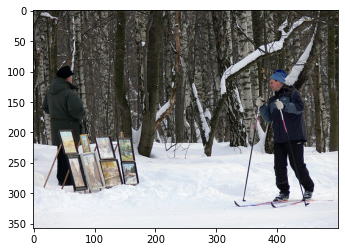

Greedy: czĹ‚owiek w i i i mÄ™ĹĽczyzna przejeĹĽdĹĽa na nartach po
['w zaśnieżonym lesie mężczyzna stoi na nartach opierając się na kijkach i patrzy na wyeksponowane na śniegu obrazy obok których stoi druga osoba', 'mężczyzna przejeżdża na nartach biegowych spoglądając na ustawione obok obrazy']


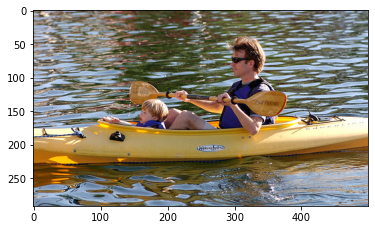

Greedy: pies z obroĹĽÄ…
['mężczyzna i dziecko płyną żółtym kajakiem', 'mężczyzna w okularach przeciwsłonecznych wraz z małym chłopcem płyną żółtym kajakiem']


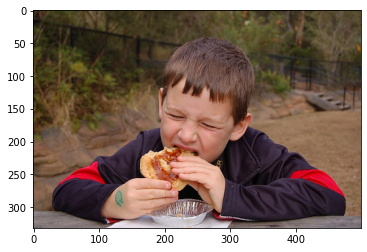

Greedy: chĹ‚opiec dzieci siÄ™ na deskorolce w pobliĹĽu
['chłopiec z niebieskim tatuażem na ręce zjada posiłek gryząc go z zamkniętymi oczami', 'chłopiec trzyma i gryzie ciastko']


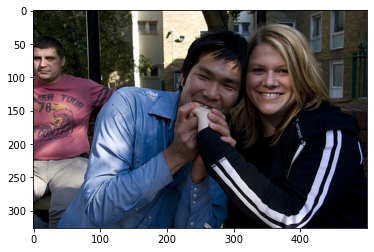

Greedy: mÄ™ĹĽczyzna pies z na szyi siedzi na mÄ™ĹĽczyzny i patrzy na psa
['skośnooki mężczyzna w niebieskiej koszuli ujmuje dłoń siedzącej obok jasnowłosej kobiety', 'mężczyzna w niebieskiej koszuli trzyma przy ustach dłoń kobiety ubranej w bluzę a obok siedzi mężczyzna w różowej bluzce']


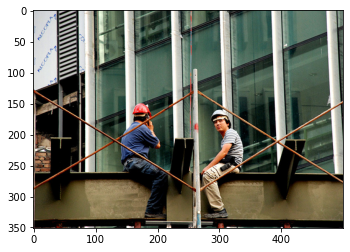

Greedy: pies z na gĹ‚owie skacze na i patrzy w na psa
['dwaj mężczyźni w kaskach budowlanych siedzą naprzeciwko siebie na elemencie konstrukcyjnym budynku', 'dwaj mężczyźni w ochronnych kaskach na głowie siedzą na elemencie konstrukcyjnym budynku']


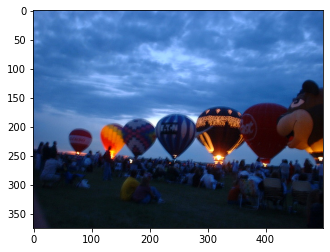

Greedy: dwie dziewczynki siÄ™ w basenie w
['ludzie siedzą o zmierzchu na trawie w pobliżu ustawionych w rzędzie balonów', 'ludzie zgromadzeni na trawie obserwują kolorowe balony powietrzne']


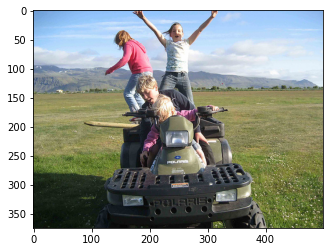

Greedy: czĹ‚owiek w kasku i na gĹ‚owie jeĹşdzi po
['na trawie niedaleko górskich wzniesień stoi quad a na nim znajduje się czwórka dzieci', 'dziewczynka i chłopiec siedzą przy kierownicy quada znajdującego się na trawie druga dziewczynka stoi za nimi z rękami w górze a trzecia dziewczynka stoi obok z ugiętymi kolanami']


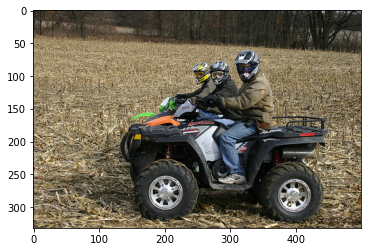

Greedy: czĹ‚owiek w kasku i kombinezonie jedzie skok
['trzy osoby w kaskach siedzą na quadach obok siebie', 'trzy osoby w kaskach siedzą jedna obok drugiej w pojazdach na rżysku']


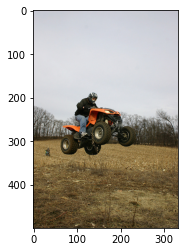

Greedy: czĹ‚owiek w kasku wykonuje skok na rowerze
['człowiek w kasku wykonuje skok na czerwonym quadzie', 'mężczyzna w kasku i czarnej kurtce wykonuje skok jadąc na quadzie']


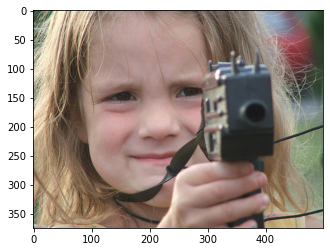

Greedy: maĹ‚y pies z do gĂłry w duĹĽy
['dziecko trzyma zabawkowy pistolet i patrzy w celownik', 'dziewczynka o ciemnych oczach patrzy na czarny przedmiot który trzyma w ręce']


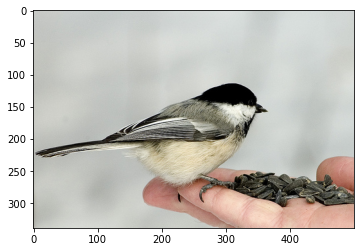

Greedy: maĹ‚y ptak z dziobem siebie na
['mały ptak siedzi na dłoni pełnej ziaren słonecznika', 'mały czarnobiały ptak siedzi na ludzkiej dłoni obok ciemnych pestek']


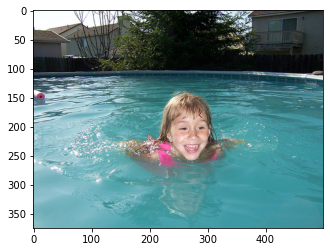

Greedy: dziewczynka w kostiumie kÄ…pielowym pĹ‚ywa pĹ‚ywa
['dziewczynka pływa w basenie uśmiechając się', 'uśmiechnięta dziewczynka w różowym stroju pływa w basenie']


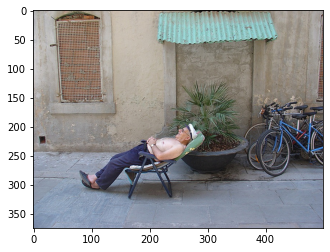

Greedy: kobieta z w rÄ™ku na w pobliĹĽu
['mężczyzna leży na leżaku pod ścianą budynku', 'cztery rowery stoją pod budynkiem w pobliżu odpoczywającego mężczyzny na leżaku']


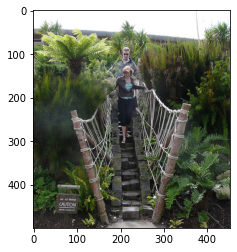

Greedy: czĹ‚owiek w czapce z rozĹ‚oĹĽonymi
['kobieta i mężczyzna schodzą po wąskich schodach trzymając się poręczy wykonanej z liny', 'kobieta i mężczyzna idą wąskimi schodkami między roślinami']


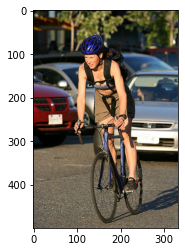

Greedy: czĹ‚owiek w kasku i kombinezonie jedzie skok na rowerze
['kobieta w niebieskim kasku jedzie na rowerze obok samochodów', 'kobieta w niebieskim kasku i z plecakiem na plecach jedzie rowerem przed srebrnym autem']


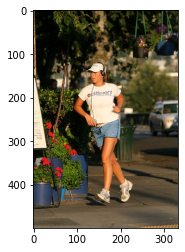

Greedy: kobieta w stroju kostiumie kÄ…pielowym na rolkach po
['kobieta w sportowym stroju i słuchawkach biegnie po chodniku', 'kobieta ze słuchawkami na uszach trenuje bieganie']


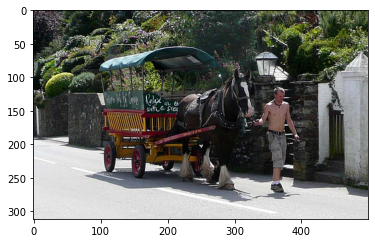

Greedy: kobieta w stroju kostiumie i z na
['mężczyzna idzie ulicą prowadząc konia z kolorową bryczką', 'mężczyzna prowadzi konia pociągowego z wozem wzdłuż muru']


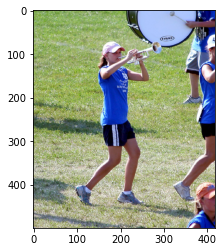

Greedy: kobieta w stroju stroju na rolkach w
['dziewczyna w sportowym stroju i czapce z daszkiem stoi na trawniku i gra na trąbce w towarzystwie innych muzyków', 'dziewczyna grająca na trąbce idzie po trawie w towarzystwie innych osób']


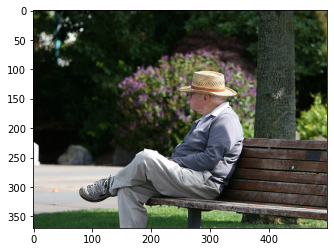

Greedy: starszy starszy mÄ™ĹĽczyzna i dzieci w czerwonym
['starszy mężczyzna w okularach i kapeluszu siedzi na brzegu ławki pod drzewem', 'starszy pan w kapeluszu siedzi na ławce z jedną nogą założoną na drugą']


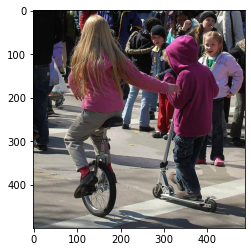

Greedy: dziewczynka jedzie w na a dziecko jedzie na
['dziewczynka w długich włosach przejeżdża monocyklem obok dziecka na hulajnodze', 'dziewczynka jedzie na monocyklu a drugie dziecko jedzie na hulajnodze']


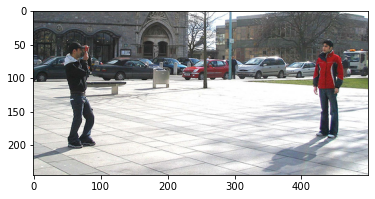

Greedy: pies z na szyi biegnie za piĹ‚kÄ…
['jeden mężczyzna robi drugiemu zdjęcie na placu', 'mężczyzna w czerwonej kurtce pozuje do zdjęcia stojąc na chodniku']


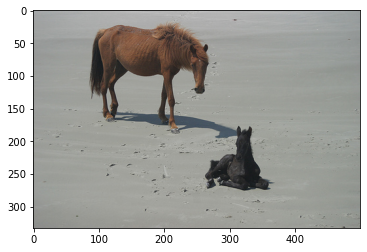

Greedy: chĹ‚opiec pies z obroĹĽÄ… na szyi biegnie po piasku
['czarny źrebak leży na plaży a obok niego stoi brązowy koń', 'dwa wychudzone konie znajdują się na piasku']


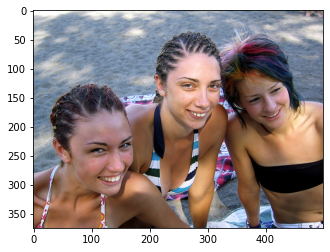

Greedy: dziewczynka w kostiumie kÄ…pielowym pĹ‚ywa pĹ‚ywa
['dwie dziewczyny z warkoczykami i jedna dziewczyna z kolorowymi włosami siedzą na piasku w kostiumach kąpielowych', 'trzy uśmiechające się młode dziewczyny w strojach kąpielowych siedzą obok siebie na piasku']


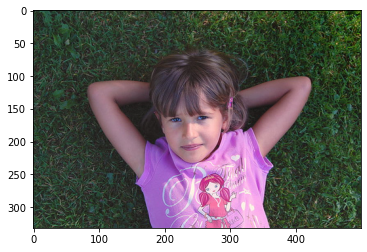

Greedy: dziewczynka o wĹ‚osach wĹ‚osach w rĂłĹĽowej stoi w stojÄ…
['dziewczynka w różowej bluzce leży na trawie z założonymi za głowę rękami', 'dziewczynka w fioletowej koszulce leży na trawie z rękami pod głową']


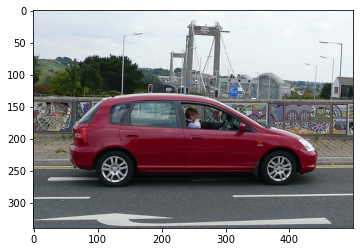

Greedy: czĹ‚owiek w i z na gĹ‚owie
['człowiek siedzi w czerwonym samochodzie w pobliżu mostu', 'osoba siedzi w aucie stojącym na pasie drogowym w pobliżu dużego mostu']


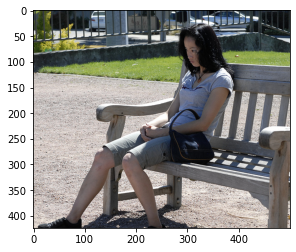

Greedy: dwoje dzieci na Ĺ‚awce
['skośnooka kobieta siedzi na drewnianej ławce z lekko spuszczoną głową', 'czarnowłosa kobieta siedzi na drewnianej ławce']


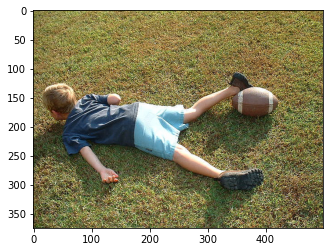

Greedy: dziewczynka w rĂłĹĽowym stroju na niedaleko
['chłopiec leży na trawie dotykając nogą podłużnej piłki', 'chłopiec leży na brzuchu na trawie a między jego nogami leży piłka']


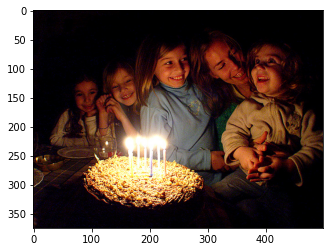

Greedy: chĹ‚opiec w kolorowych i jasnych spodniach na rolkach po
['kobieta i cztery dziewczynki siedzą przy cieście z płonącymi świeczkami', 'uśmiechnięta kobieta i cztery dziewczynki siedzą przy torcie z zapalonymi świeczkami']


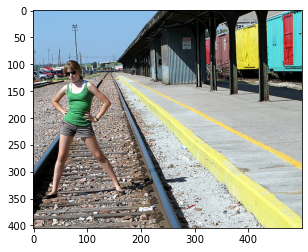

Greedy: kobieta w kostiumie kostiumie kÄ…pielowym na rolkach po placu
['dziewczyna w szortach zielonej koszulce i okularach stoi w rozkroku na torach obok stacji kolejowej', 'dziewczyna w ciemnych okularach stoi na torze obok peronu']


In [53]:
for i in range(0,30):
    pic = list(encoding_train.keys())[i]
    image = encoding_train[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print("Greedy:",greedySearch(image))
    print(descriptions[pic[:-4]])